# Brain Tumor Detection using TorchVision
Classifying Brain CT scans into Healthy and Tumor.

Using Convolutional Neural Network and TorchVision




# 1. Introduction

The accurate detection and classification of Brain Tumors play a crucial role in the diagnosis and treatment planning of patients. However, manual interpretation of Medical Images , such as MRI scans, can be time-consuming and subjective, leading to potential errors and delays in patient care. Therefore, there is a need for an automated and reliable method to detect and classify brain tumors from medical images.

# 2. Objective of the Project
This study aims to develop a Convolutional Neural Network (CNN) using the PyTorch framework that can accurately detect and classify Brain Tumors from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types. The study aims to achieve high accuracy in tumor detection and classification, providing a valuable tool for healthcare professionals in the field of neuro-oncology. The ultimate goal is to improve the efficiency and accuracy of brain tumor diagnosis, enabling timely and appropriate treatment planning for patients.

In [2]:
!pip install split-folders
!pip install torch-summary

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder as ImgFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [4]:
import kagglehub

path = kagglehub.dataset_download("preetviradiya/brian-tumor-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brian-tumor-dataset


In [5]:
labels_df = pd.read_csv(path + '/metadata.csv')
print(labels_df.head().to_markdown())
labels_df.shape

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


(4600, 6)

In [6]:
os.listdir(path +'/Brain Tumor Data Set/Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

In [7]:
# Dataset Path
data_dir = path +'/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))

Copying files: 4600 files [00:05, 817.74 files/s] 


In [8]:
# New dataset path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)


In [9]:
os.listdir('/content/brain')

['val', 'train']

In [10]:
print(data_dir)

/content/brain


In [11]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [12]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

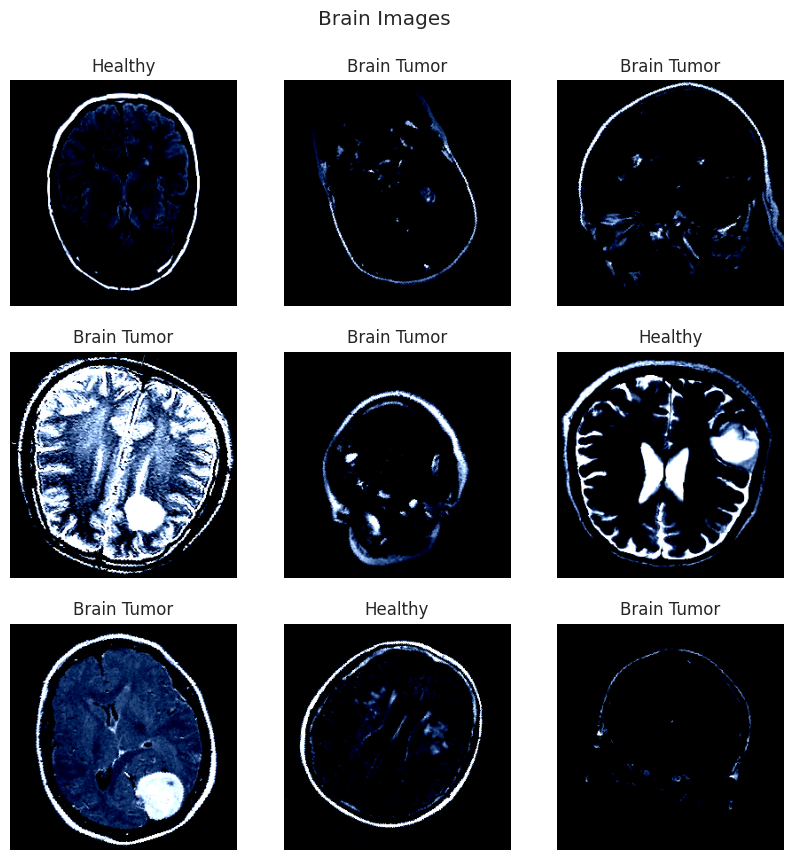

In [13]:
# Show samples
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [14]:
# load train, validation
batch_size = 64

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [15]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [16]:
# Define Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [17]:
params_model={
        "shape_in": (3,256,256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}


# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)


summary(cnn_model, input_size=(3, 256, 256),device=device.type)

loss_func = nn.NLLLoss(reduction="sum")

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


In [18]:

def loss_epoch(model,loss_func,dataset_dl,opt=None):
    '''
    Calculate the loss and metric for an epoch.
    Args:
        model: The neural network model.
        loss_func: The loss function.
        dataset_dl: The DataLoader for the dataset.
        opt: The optimizer (optional, used for training).
    Returns:
        The average loss and the accuracy for the epoch.
    '''
    running_loss=0.0
    running_metrics=0.0
    len_data = len(dataset_dl.dataset)

    for xb,yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)

        loss_b = loss_func(output,yb)
        metrics_b = accuracy(output,yb) # Assuming 'accuracy' is a defined metric function

        running_loss+=loss_b
        if opt is not None:
            opt.zero_grad()
            loss_b.backward()
            opt.step()

        running_metrics+=metrics_b


    loss = running_loss/float(len_data)
    metrics = running_metrics/float(len_data)

    return loss, metrics

def accuracy(output, target):
    '''
    Calculate the accuracy.
    Args:
        output: The model output (logits or probabilities).
        target: The true labels.
    Returns:
        The accuracy.
    '''
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        correct = (pred == target).sum().item()
        return correct




In [19]:
def Train_Val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')


# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)


        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [20]:

# The rest of your code from ipython-input-49-7db84d2ba1b2 remains the same
params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

torch.save(cnn_model, "Brain_Tumor_model.pt")

  0%|          | 0/60 [00:00<?, ?it/s]

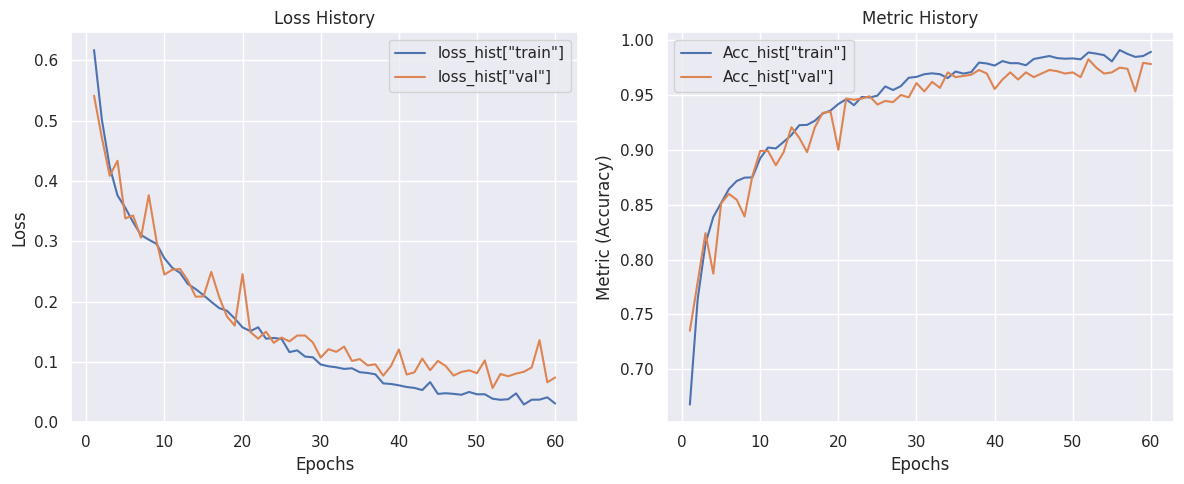

In [31]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

# Convert GPU tensors in loss_hist and metric_hist to CPU for plotting
for history in [loss_hist, metric_hist]:
    for key in history:
        # Convert each item in the list to a scalar (float) if it's a tensor or numpy array
        history[key] = [item.detach().cpu().item() if isinstance(item, torch.Tensor) else item.item() if isinstance(item, np.ndarray) else item for item in history[key]]


# Plotting the histories
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

# Add labels and titles for clarity
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss History")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Metric (Accuracy)")
ax[1].set_title("Metric History")
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [32]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       503
         1.0       0.97      0.99      0.98       418

    accuracy                           0.98       921
   macro avg       0.98      0.98      0.98       921
weighted avg       0.98      0.98      0.98       921
 




## Confusion Matrix

A confusion matrix is a table that summarizes how well a classification model performs by comparing actual vs predicted labels. It shows the count of true positives, false positives, true negatives, and false negatives. In a brain tumor detection model using CNN, it helps identify if the model is correctly classifying tumor presence vs absence. This is crucial in medical diagnostics where false negatives (missing a tumor) can be dangerous. The matrix allows us to compute metrics like accuracy, precision, and recall to evaluate and improve the model’s reliability.

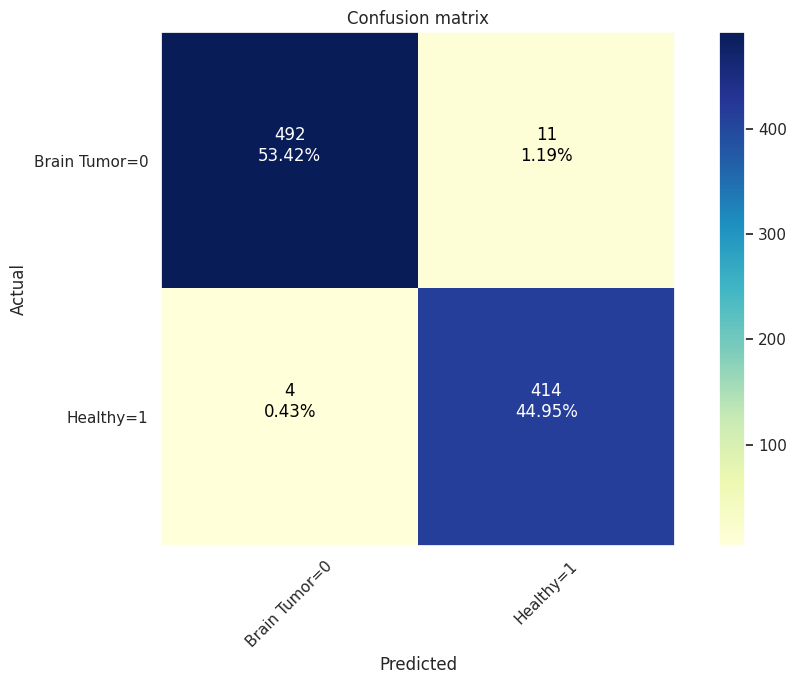

In [33]:
# a very interesting technique i learnt back from Linear Regression California housing model
# When you wanna fine the if all features are MECE, then you can what features are co-dependant here
# helps with feature engineering much
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)